# Predict receipt price with generated code

For the second try, I am using Chat GPT-3 to generate code that will create the model. 

## 1. Setting up the data

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import json

warnings.filterwarnings(action='error')

In [2]:
# Load the data into a Pandas DataFrame
df = pd.read_csv("Receipts August 2022 - V6.csv")
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['time of exit'] = pd.to_datetime(df['time of exit'], format='%H:%M:%S')

# Adding all the columns from third EDA
df['dow'] = df['date'].dt.day_of_week
df['is w'] = df['dow'] > 4
df['is nem'] = df['dow'].apply(lambda dow: 3 < dow < 6)
df['toe hour'] = df['time of exit'].dt.hour
df['toe minute'] = df['time of exit'].dt.minute
df['toe as n'] = df['toe hour'] + df['toe minute'] / 60
df.drop(columns=['id'], inplace=True)

# Removing the anomalies
df = df[df['toe as n'] > 15]
df = df[df['receipt price'] < 200]

## 2. Using Chat GPT-3

I chose to predict `receipt price`. To predict this, I chose the highest numbers on the correlation matrix which are `toe as n` (0.31) and `is nem` (0.11). But `dow` will be used because it indirectly includes `is nem`.

Below is the generated code. The input promt was something along the lines of: *"Could you predict receipt price from the following columns: date, time, day of week. Use python"*. The columns were purposefully changed so the AI could understand it better. But retrospectively, it probably would not make a difference.

In [3]:
# Extract the relevant columns from the DataFrame
X = df[['toe as n', 'dow']]
y = df['receipt price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Train the linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model's performance on the testing data
print(model.score(X_test, y_test))

-0.08032381115121057


## 3. Modifying the generated script

The printed model score varies a lot every time this script is run. This is because of the small dataset. The training data is very scarce, causing the model to be sensitive to a small change in training data. To get around this issue, the generated script will be modified by putting it in a for-loop to get the highest model score. Then The best performing model will be selected. This loop will run inside another loop that iterates through a list of learning rates. The reason for the outer loop is that the learning rate will also have a significant effect on the on the training data. Again because the total data is minimal.

In [4]:
# Define the number of iterations to run the model fitting to get the best performing model
iterations = 1000

# Define the list that will contain the model scores for the x amount of iterations.
# This list will be used later on for plotting purposes.
best_performing_learning_rate_model_scores = []

# The list will be overwritten when the below variable is increased
best_performing_learning_rate = 0

In [5]:
def train_model(learning_rate):
    # Reset the global values
    global model_scores
    global highest_model_score
    global average_model_score
    global final_X_test
    global final_y_test
    global strongest_model

    model_scores = [] 
    highest_model_score = -10
    average_model_score = -10
    final_X_test = pd.DataFrame()
    final_y_test = pd.DataFrame()
    strongest_model = LinearRegression()

    # Sidenote: -10 is because the score can be lower than 0. This allows for negative values for the 2 variables when comparing against older values. 
    # This will make sense when looking at the update_model_stats() method

    # Train the linear regression model on the training data
    for i in range(iterations):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

        # Train the linear regression model on the training data
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Evaluate the model's performance on the testing data
        model_score = model.score(X_test, y_test)
        model_scores.append([i, model_score])

        # If this model is better, update the strongest/highest scoring model
        if model_score > highest_model_score:
            highest_model_score = model_score
            strongest_model = model
            final_X_test = X_test
            final_y_test = y_test

    # Set average score
    average_model_score = np.average(model_scores, axis=0)[1]   

In [6]:
# %%time
data = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
        'highest_model_score': [0, 0, 0, 0, 0, 0, 0, 0],
        'average_model_score': [0, 0, 0, 0, 0, 0, 0, 0],
        'strongest_model': [None, None, None, None, None, None, None, None]}

learning_rates_differences = pd.DataFrame(data)

best_learning_rate_highest_model_score = 0

for index, row in learning_rates_differences.iterrows():
    train_model(row["learning_rate"])
    learning_rates_differences.loc[index, 'highest_model_score'] = highest_model_score
    learning_rates_differences.loc[index, 'strongest_model'] = strongest_model
    learning_rates_differences.loc[index, 'average_model_score'] = average_model_score

    if highest_model_score > best_learning_rate_highest_model_score:
        best_learning_rate_highest_model_score = highest_model_score
        best_performing_learning_rate_model_scores = model_scores
        best_performing_learning_rate = row["learning_rate"]

print(learning_rates_differences)
print(f"{len(learning_rates_differences.index)} learning rates * {iterations} iterations = {len(learning_rates_differences.index) * iterations} total iterations with dataset size of {len(df.index)} records")


   learning_rate  highest_model_score  average_model_score     strongest_model
0           0.05             0.409405            -0.015826  LinearRegression()
1           0.10             0.373194            -0.006267  LinearRegression()
2           0.15             0.397737             0.007070  LinearRegression()
3           0.20             0.442695            -0.007234  LinearRegression()
4           0.25             0.482485            -0.026128  LinearRegression()
5           0.30             0.439695            -0.007950  LinearRegression()
6           0.35             0.404947            -0.007662  LinearRegression()
7           0.40             0.394423            -0.014384  LinearRegression()
8 learning rates * 1000 iterations = 8000 total iterations with dataset size of 185 records


### 3.1 Documenting the model inconsistency

The average models score are negative meaning that the average model is useless. Below are some charts that show the variation from the all the iterations from the highest performing learning rate.

In [7]:
# Describing the model scores array as a dataframe
x = np.array(best_performing_learning_rate_model_scores)[:, 1]
pd.DataFrame(x).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,1000.0,-0.026128,0.26675,-3.380795,-0.09731,0.030113,0.118997,0.482485


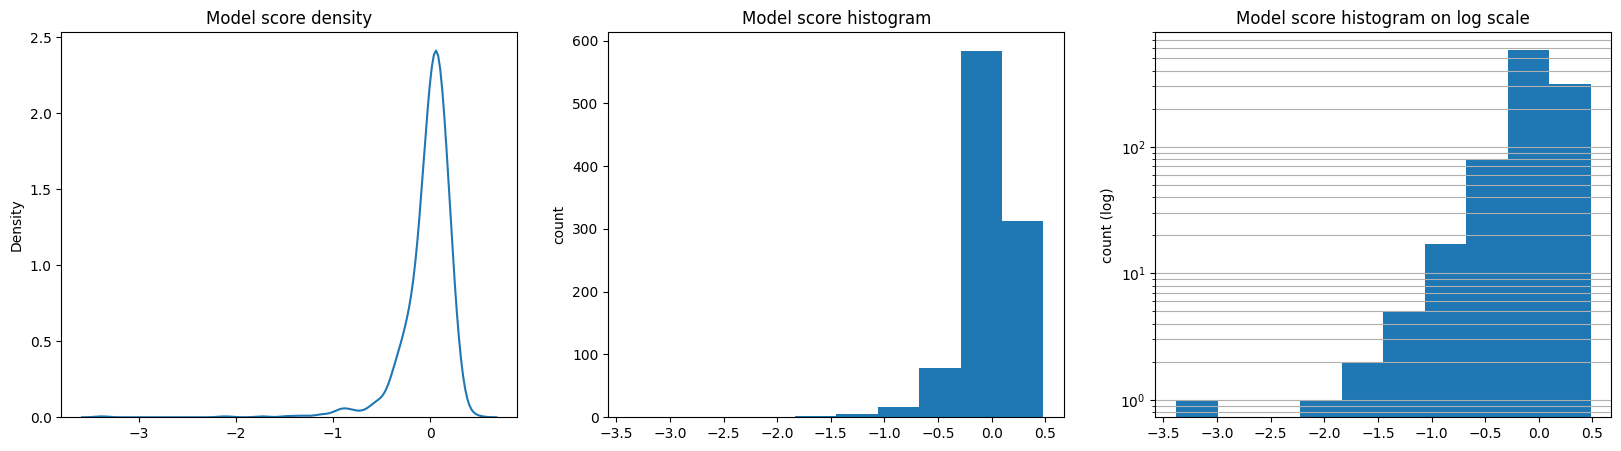

In [8]:
fig, ax =   plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Model score density")
sns.kdeplot(x, ax=ax[0])

ax[1].set_title("Model score histogram")
ax[1].set_ylabel("count")
ax[1].hist(x)

ax[2].set_title("Model score histogram on log scale")
ax[2].set_ylabel("count (log)")
ax[2].hist(x, log=True)
ax[2].grid(visible=True, axis="y", which="both")

## 4. Using the strongest model

### 4.1 Selecting the strongest model

Let's first select the strongest model

<AxesSubplot: >

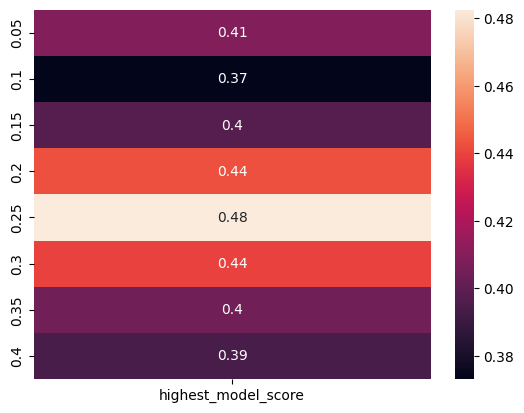

In [9]:
# Display the dataframe as a heatmap
sns.heatmap(learning_rates_differences[["highest_model_score"]], annot=True, yticklabels=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])

The above plot is not necessary but it gives visual confirmation of which learning rate performs the best. Now, this best performing model will be used.

In [10]:
# Filter and print the best performing model
best_performing_learning_rate = learning_rates_differences[learning_rates_differences['highest_model_score'] == learning_rates_differences['highest_model_score'].max()]
print(best_performing_learning_rate)

model = best_performing_learning_rate['strongest_model'].values[0]

   learning_rate  highest_model_score  average_model_score     strongest_model
4           0.25             0.482485            -0.026128  LinearRegression()


The best performing learning rate is stored in a json file to see the consistency of over time. This is done in this manner to relieve some pressure from the pc that is running this notebook.

In [11]:
# Read the json file
with open('best learning rate frequency.json', 'r') as f:
    data = json.load(f)

# Write the json file
with open('best learning rate frequency.json', 'w') as f:
    # Add 1 to the value where key equals the learning rate
    for key, value in data.items():
        lr = best_performing_learning_rate["learning_rate"].values[0]
        if key == str(lr):
            data[key] = value + 1

    json.dump(data, f)  
    
    print(data)

{'0.05': 0, '0.1': 0, '0.15': 0, '0.2': 1, '0.25': 1, '0.3': 0, '0.35': 2, '0.4': 0}


### 4.2 Applying the strongest model

Now, let's use the strongest model and apply the test data.

In [12]:
# Use the model to make predictions on new data
result = strongest_model.predict(pd.DataFrame({'toe as n': [20.5], 'dow': [1]}))[0]
print(f"Predicted receipt price: €{result:.2f}")

Predicted receipt price: €67.91


The model works: it gave a predicted receipt price. Lets use the test data to predict

In [13]:
predictions = model.predict(final_X_test)
predicted_vs_actual_df = pd.DataFrame({'prediction': predictions, 'actual': final_y_test})

predicted_df = pd.DataFrame({'receipt price': predictions, 'toe as n': final_X_test['toe as n'], 'dow': final_X_test['dow']})
input_df = pd.DataFrame({'receipt price': final_y_test, 'toe as n': final_X_test['toe as n'], 'dow': final_X_test['dow']})

### 4.3 Analyzing the results
Now, let's analyze the accuracy

In [14]:
# Calculate the mean squared error
mse = ((predicted_vs_actual_df['prediction'] - predicted_vs_actual_df['actual']) ** 2).mean()
print('Mean Squared Error:', mse)

# Calculate the root mean squared error
rmse = mse ** 0.5
print('Root Mean Squared Error:', rmse)

# Calculate the coefficient of determination (R^2 score)
r2 = model.score(X_test, y_test)
print('R^2 Score:', r2)

Mean Squared Error: 407.9509311802253
Root Mean Squared Error: 20.197795205918524
R^2 Score: -0.010801148585215303


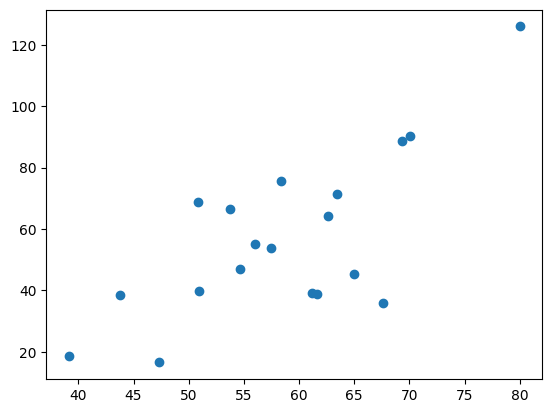

In [15]:
# Plotting the predictions
plt.scatter(predicted_vs_actual_df['prediction'], predicted_vs_actual_df["actual"])

// Make an observation on the above numbers

Visual analysis

Let's look at the prediction lines

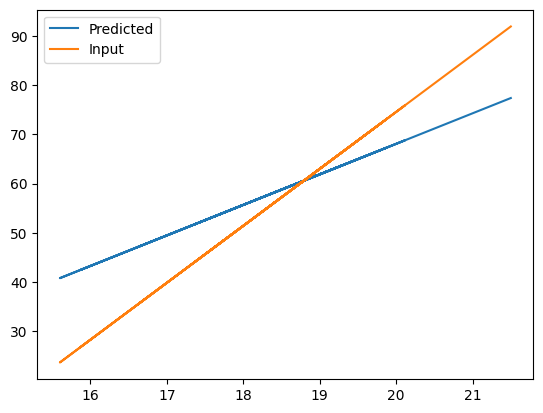

In [16]:
def plot_prediction_line(x, y, label):
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    plt.plot(x, m*x+b, label=label)

plot_prediction_line(predicted_df["toe as n"], predicted_df["receipt price"], "Predicted")
plot_prediction_line(input_df["toe as n"], input_df["receipt price"], "Input")

plt.legend()

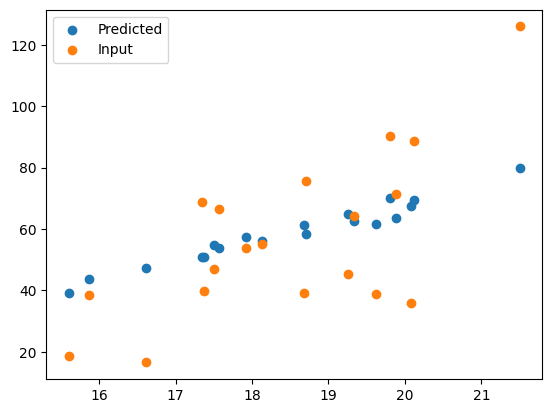

In [17]:
# Plotting the predictions
plt.scatter(predicted_df["toe as n"], predicted_df["receipt price"]).set_label("Predicted")

# Plotting the ipnut
plt.scatter(input_df["toe as n"], input_df["receipt price"]).set_label("Input")

plt.legend()

Lets add another party to the plot by translating the predicted values. This way the difference between the predicted value and the actual value is shon on both sides of the input.

In [18]:
predicted_translated_df = predicted_df.copy()

for index, row in predicted_df.iterrows():
    p_rp, tn, dow = row
    i_rp = input_df.loc[index]["receipt price"]
    diff = p_rp - i_rp
    predicted_translated_df.loc[index, "receipt price"] = p_rp - (diff * 2)

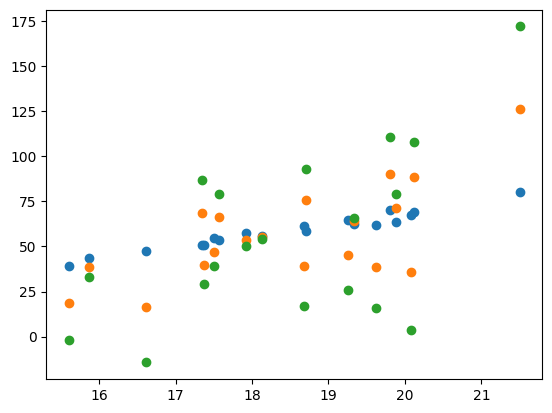

In [19]:
# Plot the predictions
plt.scatter(predicted_df["toe as n"], predicted_df["receipt price"]).set_label("Predicted")

# Plot the ipnut
plt.scatter(input_df["toe as n"], input_df["receipt price"]).set_label("Input")

# Plot the translated predictions
plt.scatter(predicted_translated_df["toe as n"], predicted_translated_df["receipt price"]).set_label("Predicted (trans)")

The above plot is not very clear. Let's add a shadow band.

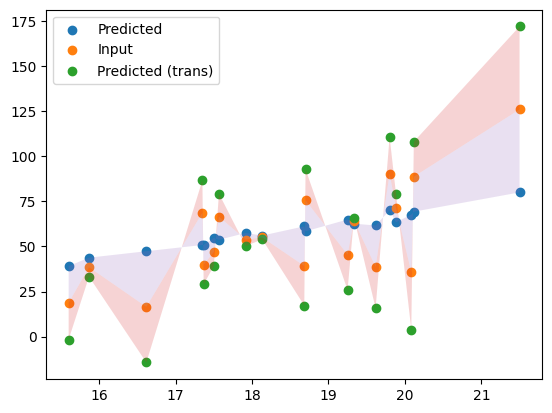

In [20]:
# Sort the dataframes to ensure that the fill_between function works correctly
sorted_predicted_df = predicted_df.sort_values(by=["toe as n"])
sorted_input_df = input_df.sort_values(by=["toe as n"])
sorted_predicted_translated_df = predicted_translated_df.sort_values(by=["toe as n"])

# Plot the predictions
plt.scatter(predicted_df["toe as n"], predicted_df["receipt price"]).set_label("Predicted")

# Plot the ipnut
plt.scatter(input_df["toe as n"], input_df["receipt price"]).set_label("Input")

# Plot the translated predictions
plt.scatter(predicted_translated_df["toe as n"], predicted_translated_df["receipt price"]).set_label("Predicted (trans)")

# Fill the area between the translated predictions and the input
plt.fill_between(sorted_input_df["toe as n"], sorted_predicted_translated_df["receipt price"], sorted_input_df["receipt price"], alpha=0.2)

# Fill the area between the predictions and the input
plt.fill_between(sorted_input_df["toe as n"], sorted_predicted_df["receipt price"], sorted_input_df["receipt price"], alpha=0.2)

plt.legend()

This does not look right ...

In [21]:
upper_values = []
lower_values = []

for index, row in sorted_input_df.iterrows():
    # i_rp, tn, dow = row
    p_rp = sorted_predicted_df.loc[index]["receipt price"]
    pt_rp = sorted_predicted_translated_df.loc[index]["receipt price"]
    p_is_higher = p_rp > pt_rp
    upper_values.append(p_rp if p_is_higher else pt_rp)
    lower_values.append(pt_rp if p_is_higher else p_rp)

limits_df = pd.DataFrame({'upper': upper_values, 'lower': lower_values, 'input': sorted_input_df["receipt price"]})

Text(0, 0.5, 'receipt price')

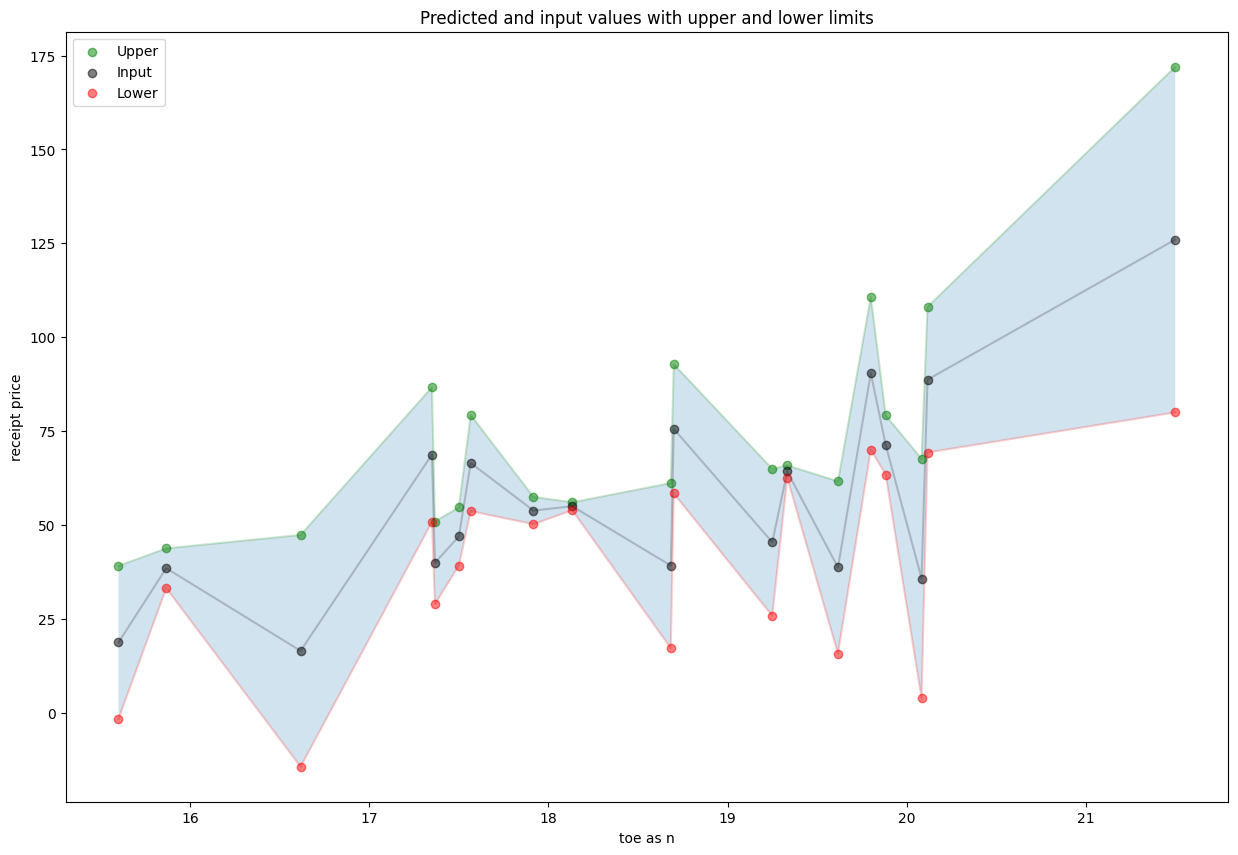

In [22]:
fig, ax = plt.subplots(figsize = (15, 10))

# Fill the area between the upper and lower values
plt.fill_between(sorted_input_df["toe as n"], limits_df["upper"], limits_df["lower"], alpha=0.2)

# Plot the upper values
plt.scatter(sorted_input_df["toe as n"], limits_df["upper"], color='green', alpha=0.5).set_label("Upper")

# Plot the ipnut
plt.scatter(sorted_input_df["toe as n"], sorted_input_df["receipt price"], color='black', alpha=0.5).set_label("Input")

# Plot the lower values
plt.scatter(sorted_input_df["toe as n"], limits_df["lower"], color='red', alpha=0.5).set_label("Lower")

# Add lines through the dots for better readability
plt.plot(sorted_input_df["toe as n"], limits_df["upper"], color='green', alpha=0.2)
plt.plot(sorted_input_df["toe as n"], sorted_input_df["receipt price"], color='black', alpha=0.2)
plt.plot(sorted_input_df["toe as n"], limits_df["lower"], color='red', alpha=0.2)

plt.legend()
plt.title("Predicted and input values with upper and lower limits")
plt.xlabel("toe as n")
plt.ylabel("receipt price")

In [23]:
average_difference_in_percentages_for_highest_scoring_model = input_df["receipt price"].subtract(predicted_df["receipt price"]).divide(input_df["receipt price"]).abs().mean() * 100
average_difference_in_percentages_for_highest_scoring_model

40.63582167694746

I am curious to see the difference between when the strongest model is chosen based on the average model score:

In [24]:
best_performing_learning_rate = learning_rates_differences[learning_rates_differences['average_model_score'] == learning_rates_differences['average_model_score'].max()]
print(best_performing_learning_rate)

model = best_performing_learning_rate['strongest_model'].values[0]

predictions = model.predict(final_X_test)

predicted_df = pd.DataFrame({'receipt price': predictions, 'toe as n': final_X_test['toe as n'], 'dow': final_X_test['dow']})
predicted_vs_actual_df = pd.DataFrame({'prediction': predictions, 'actual': final_y_test})

   learning_rate  highest_model_score  average_model_score     strongest_model
2           0.15             0.397737              0.00707  LinearRegression()


In [25]:
mse = ((predicted_vs_actual_df['prediction'] - predicted_vs_actual_df['actual']) ** 2).mean()
print('Mean Squared Error:', mse)

rmse = mse ** 0.5
print('Root Mean Squared Error:', rmse)

r2 = model.score(X_test, y_test)
print('R^2 Score:', r2)

Mean Squared Error: 401.7169528370264
Root Mean Squared Error: 20.042877858157656
R^2 Score: 0.011610769473399007


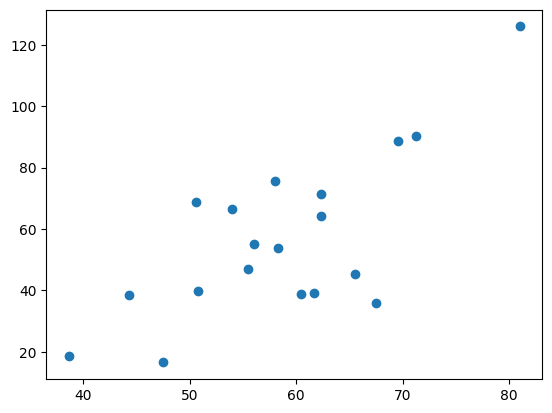

In [26]:
plt.scatter(predicted_vs_actual_df['prediction'], predicted_vs_actual_df["actual"])

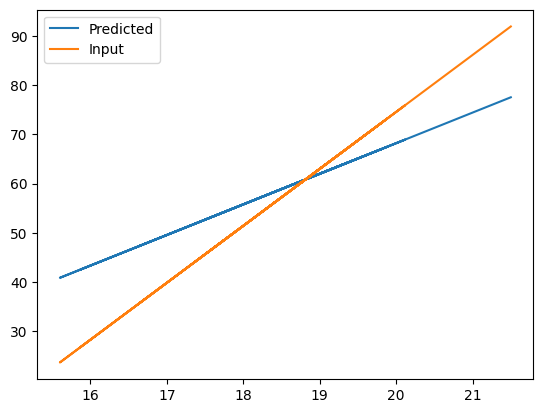

In [27]:
plot_prediction_line(predicted_df["toe as n"], predicted_df["receipt price"], "Predicted")
plot_prediction_line(input_df["toe as n"], input_df["receipt price"], "Input")

plt.legend()

In [28]:
sorted_predicted_df = predicted_df.sort_values(by=["toe as n"])
sorted_input_df = input_df.sort_values(by=["toe as n"])
sorted_predicted_translated_df = predicted_translated_df.sort_values(by=["toe as n"])

upper_values = []
lower_values = []

for index, row in sorted_input_df.iterrows():
    # i_rp, tn, dow = row
    p_rp = sorted_predicted_df.loc[index]["receipt price"]
    pt_rp = sorted_predicted_translated_df.loc[index]["receipt price"]
    p_is_higher = p_rp > pt_rp
    upper_values.append(p_rp if p_is_higher else pt_rp)
    lower_values.append(pt_rp if p_is_higher else p_rp)

limits_df = pd.DataFrame({'upper': upper_values, 'lower': lower_values, 'input': sorted_input_df["receipt price"]})

Text(0, 0.5, 'receipt price')

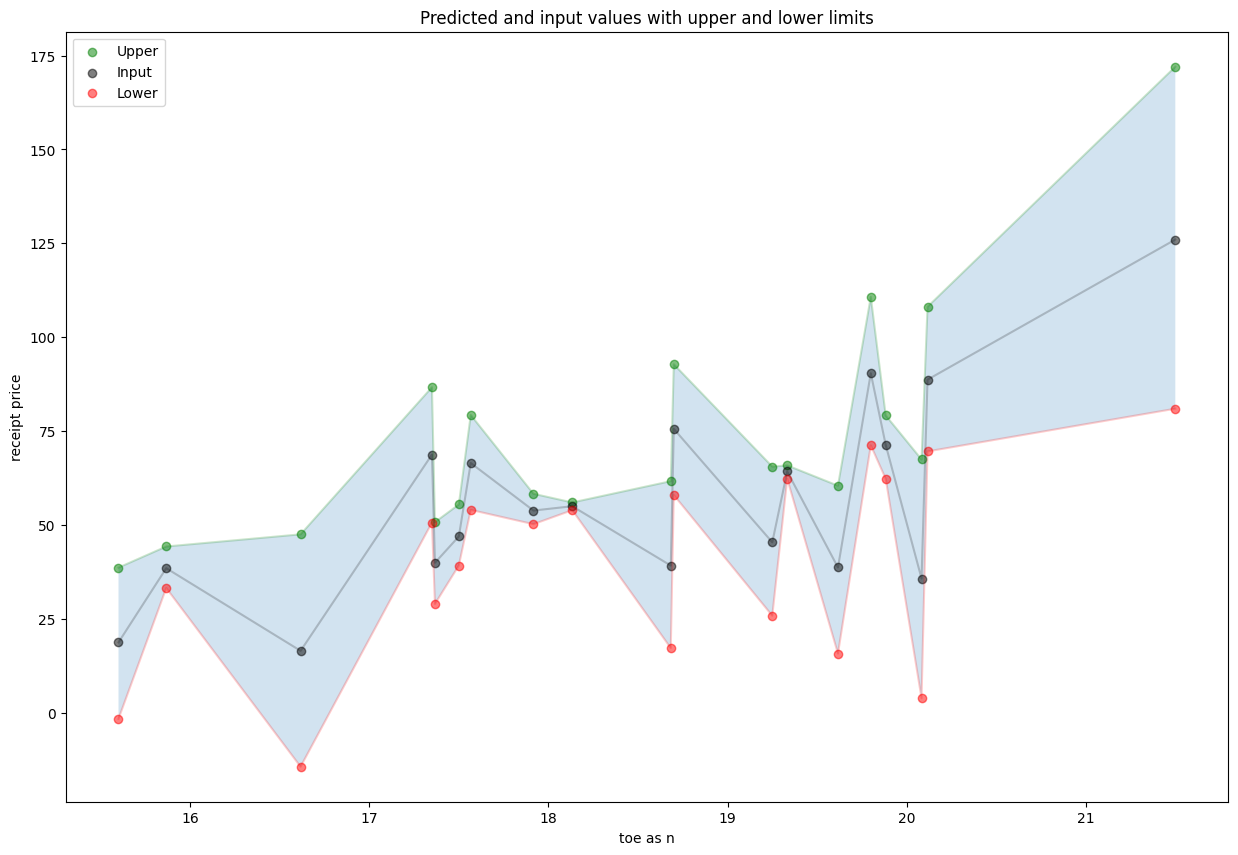

In [29]:
fig, ax = plt.subplots(figsize = (15, 10))

# Fill the area between the upper and lower values
plt.fill_between(sorted_input_df["toe as n"], limits_df["upper"], limits_df["lower"], alpha=0.2)

# Plot the upper values
plt.scatter(sorted_input_df["toe as n"], limits_df["upper"], color='green', alpha=0.5).set_label("Upper")

# Plot the ipnut
plt.scatter(sorted_input_df["toe as n"], sorted_input_df["receipt price"], color='black', alpha=0.5).set_label("Input")

# Plot the lower values
plt.scatter(sorted_input_df["toe as n"], limits_df["lower"], color='red', alpha=0.5).set_label("Lower")

# Add lines through the dots for better readability
plt.plot(sorted_input_df["toe as n"], limits_df["upper"], color='green', alpha=0.2)
plt.plot(sorted_input_df["toe as n"], sorted_input_df["receipt price"], color='black', alpha=0.2)
plt.plot(sorted_input_df["toe as n"], limits_df["lower"], color='red', alpha=0.2)

plt.legend()
plt.title("Predicted and input values with upper and lower limits")
plt.xlabel("toe as n")
plt.ylabel("receipt price")

In [30]:
average_difference_in_percentages_for_highest_average_scoring_model = input_df["receipt price"].subtract(predicted_df["receipt price"]).divide(input_df["receipt price"]).abs().mean() * 100
average_difference_in_percentages_for_highest_average_scoring_model

40.71987604281128

Lets look at the average difference in percentages from both models

In [31]:
print(f"average strongest model: {average_difference_in_percentages_for_highest_average_scoring_model}")
print(f"highest scoring model: {average_difference_in_percentages_for_highest_scoring_model}")

average strongest model: 40.71987604281128
highest scoring model: 40.63582167694746


# Conclusion

The charts show that I have succesfully created a regression model using partly generated code by Chat GPT-3. I say "succesfully". But everything could change when there is a valid amount of data. I doassume that the model gets more accurate as the data volume increases.